# Задание 3: Кастомные слои и эксперименты

## 3.1. Реализация кастомных слоев

### Импорт библиотек

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as v2
import numpy as np
import matplotlib.pyplot as plt

### Кастомные слои

#### Кастомный сверточный слой с доп. логикой

In [4]:
class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # Основные параметры, как у стандартной свертки
        self.weight = nn.Parameter(torch.empty(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.empty(out_channels))
    
        # Правильная инициализация Кайминга
        nn.init.kaiming_normal_(self.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.bias, 0)
        
        # Дополнительные параметры
        self.channel_scaler = nn.Parameter(torch.ones(out_channels))
        self.channel_shift = nn.Parameter(torch.zeros(out_channels))

    def forward(self, x):
        # Стандартная свертка
        conv_out = F.conv2d(
            x, self.weight, self.bias,
            self.stride, self.padding
        )
        
        # Дополнительная логика: масштабирование и сдвиг по каналам
        scaled_out = conv_out * self.channel_scaler[None, :, None, None]
        shifted_out = scaled_out + self.channel_shift[None, :, None, None]
        
        return shifted_out

# Тестирование
custom_conv = CustomConv2d(3, 16, kernel_size=3, padding=1)
std_conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)

# Копируем веса из стандартного в кастомный
with torch.no_grad():
    custom_conv.weight.copy_(std_conv.weight)
    custom_conv.bias.copy_(std_conv.bias)
    
    # Отключаем дополнительную логику
    custom_conv.channel_scaler.fill_(1.0)
    custom_conv.channel_shift.fill_(0.0)

x = torch.randn(2, 3, 32, 32)

# Проверка forward
custom_out = custom_conv(x)
std_out = std_conv(x)

# Метрики сравнения
diff = custom_out - std_out

print("Сравнение слоев при одинаковых весах:")
print(f"Максимальное расхождение: {torch.max(torch.abs(diff)).item():.6f}")
print(f"Среднее расхождение: {torch.mean(torch.abs(diff)).item():.6f}")
print(f"Косинусная близость: {F.cosine_similarity(custom_out.flatten(), std_out.flatten(), dim=0).item():.6f}")

# Проверка backward
custom_out.sum().backward()
std_out.sum().backward()

print("\nСравнение градиентов:")
print(f"Разница градиентов весов: {torch.max(torch.abs(custom_conv.weight.grad - std_conv.weight.grad)).item():.6f}")
print(f"Разница градиентов смещений: {torch.max(torch.abs(custom_conv.bias.grad - std_conv.bias.grad)).item():.6f}")

Сравнение слоев при одинаковых весах:
Максимальное расхождение: 0.000000
Среднее расхождение: 0.000000
Косинусная близость: 1.000000

Сравнение градиентов:
Разница градиентов весов: 0.000000
Разница градиентов смещений: 0.000000


#### Attention механизм

In [66]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8):
        super().__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1),
            nn.Sigmoid()
        )
        
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        ca = self.channel_attention(x)
        ca_out = x * ca
        
        sa = self.spatial_attention(ca_out)
        sa_out = ca_out * sa
        
        return sa_out

# Тестирование
attn = SpatialAttention(16)
attn_out = attn(out)
print(f"Размеры кастомного attention: {attn_out.shape}")

# Сравнение с глобальным пулингом
global_pool = nn.AdaptiveAvgPool2d(1)(out)
print("Размер после глобального пулинга:", global_pool.shape)

Размеры кастомного attention: torch.Size([2, 16, 32, 32])
Размер после глобального пулинга: torch.Size([2, 16, 1, 1])


#### Кастомная функция активации

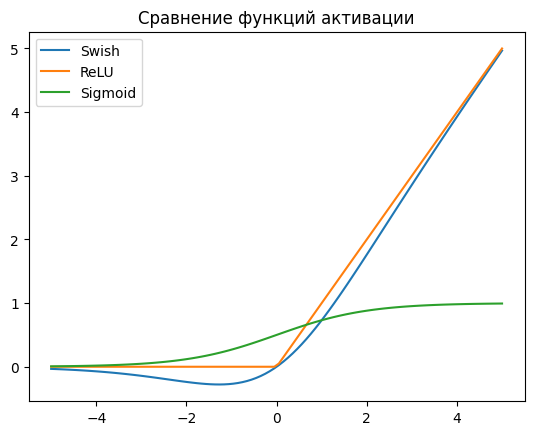

In [5]:
class Swish(nn.Module):
    def __init__(self, beta=1.0):
        super().__init__()
        self.beta = nn.Parameter(torch.tensor(beta))
        self.beta.register_hook(lambda grad: torch.clamp(grad, -0.1, 0.1))
        
    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)

# Тестирование
swish = Swish()
x = torch.linspace(-5, 5, 100)
y = swish(x)

relu = nn.ReLU()(x)
sigmoid = nn.Sigmoid()(x)

# Визуализация
plt.plot(x.numpy(), y.detach().numpy(), label='Swish')
plt.plot(x.numpy(), relu.numpy(), label='ReLU')
plt.plot(x.numpy(), sigmoid.numpy(), label='Sigmoid')
plt.legend()
plt.title("Сравнение функций активации")
plt.savefig("plots/swish_task_3_1.jpg")
plt.show()

#### Кастомный pooling слой (Lp-пулинг)

In [64]:
class LpPool2d(nn.Module):
    def __init__(self, p=2, kernel_size=2, stride=2):
        super().__init__()
        self.p = p
        self.kernel_size = kernel_size
        self.stride = stride
        
    def forward(self, x):
        # Разделение на окна
        unfolded = x.unfold(2, self.kernel_size, self.stride) \
                   .unfold(3, self.kernel_size, self.stride)
        
        # Размеры [batch, channels, h_windows, w_windows, kernel, kernel]
        windowed = unfolded.contiguous().view(*unfolded.size()[:4], -1)
        
        # Вычисление Lp-нормы
        lp_val = torch.mean(torch.abs(windowed)**self.p, dim=-1)
        result = lp_val**(1/self.p)
        
        return result

# Тестирование
pool = LpPool2d(p=1.5)  # L1.5 pooling
pool_out = pool(out)
print(f"Размеры кастомного пулинга LpPool: {pool_out.shape}")  # [2, 16, 16, 16]

# Сравнение со стандартным пулингом
avg_pool = nn.AvgPool2d(2)(out)
max_pool = nn.MaxPool2d(2)(out)
print("AvgPool:", torch.mean(avg_pool).item())
print("MaxPool:", torch.mean(max_pool).item())
print("LpPool:", torch.mean(pool_out).item())

Размеры кастомного пулинга LpPool: torch.Size([2, 16, 16, 16])
AvgPool: -0.02376679517328739
MaxPool: 5.301431655883789
LpPool: 4.490630149841309


## 3.2. Эксперименты с Residual блоками

### Импорт библиотек

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt
import numpy as np
import time
import gc

### Подготовка данных

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
epochs = 15
lr = 0.1
momentum = 0.9
weight_decay = 5e-4

transform = v2.Compose([
    v2.RandomCrop(32, padding=4),
    v2.RandomHorizontalFlip(),
    v2.ToTensor(),
    v2.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Residual блоки

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class BottleneckResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction=4):
        super().__init__()
        bottleneck_channels = out_channels // reduction
        
        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)
        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, 3, stride, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)
        self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class WideResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, width_factor=2):
        super().__init__()
        wide_channels = out_channels * width_factor
        
        self.conv1 = nn.Conv2d(in_channels, wide_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(wide_channels)
        self.conv2 = nn.Conv2d(wide_channels, wide_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(wide_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != wide_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, wide_channels, 1, stride, bias=False),
                nn.BatchNorm2d(wide_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

### Модель для обучения

In [12]:
class DiffBlocksNN(nn.Module):
    def __init__(self, block_type, num_blocks, width_factor=1):
        super().__init__()
        self.in_channels = 64
        self.width_factor = width_factor if block_type == 'wide' else 1
        
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block_type, 64, num_blocks[0], 1)
        self.layer2 = self._make_layer(block_type, 128, num_blocks[1], 2)
        self.layer3 = self._make_layer(block_type, 256, num_blocks[2], 2)
        self.layer4 = self._make_layer(block_type, 512, num_blocks[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Исправление: учитываем width_factor в финальном слое
        final_features = 512 * self.width_factor
        self.fc = nn.Linear(final_features, 10)
        
    def _make_layer(self, block_type, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            if block_type == 'basic':
                layers.append(ResidualBlock(self.in_channels, out_channels, stride))
                self.in_channels = out_channels
            elif block_type == 'bottleneck':
                layers.append(BottleneckResidualBlock(self.in_channels, out_channels, stride))
                self.in_channels = out_channels
            elif block_type == 'wide':
                layers.append(WideResidualBlock(self.in_channels, out_channels, stride, self.width_factor))
                self.in_channels = out_channels * self.width_factor
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### Функции обучения одной эпохи

In [14]:
def create_model(block_type):
    num_blocks = [2, 2, 2, 2]
    width_factor = 2 if block_type == 'wide' else 1
    return DiffBlocksNN(block_type, num_blocks, width_factor)

# Функции для обучения
def train_epoch(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss, correct = 0, 0
    start_time = time.time()
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.cross_entropy(y_pred, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    
    epoch_time = time.time() - start_time
    train_loss = total_loss / len(train_loader)
    train_acc = correct / len(train_loader.dataset)
    return train_loss, train_acc, epoch_time

def val_epoch(model, device, val_loader):
    model.eval()
    total_loss, correct = 0, 0
    start_time = time.time()
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            y_pred = model(data)
            total_loss += F.cross_entropy(y_pred, target).item()
            pred = y_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    inference_time = time.time() - start_time
    val_loss = total_loss / len(val_loader)
    val_acc = correct / len(val_loader.dataset)
    return val_loss, val_acc, inference_time

### Функция визуализации

In [20]:
def visualize_results(block_types, results):
    """
    Создает графики для каждой модели для визуализации:
        - Точности на вадиционном наборе;
        - Функции потерь на валидацинном наборе;
        - Времени обучения на одну эпоху;
        - Использования памяти ГПУ;
        - Среднего времени инференса;
        - Общего времени на обучения.
    """
    plt.figure(figsize=(18, 12))

    # Точность на валидационном наборе
    plt.subplot(2, 3, 1)
    for block_type in block_types:
        plt.plot(results[block_type]['val_acc'], label=f"{block_type} (final={results[block_type]['val_acc'][-1]*100:.2f}%)")
    plt.title('Валидационная точность')
    plt.xlabel('Эпохи')
    plt.ylabel('Точность')
    plt.legend()
    
    # Функция потерь на валидационном наборе
    plt.subplot(2, 3, 2)
    for block_type in block_types:
        plt.plot(results[block_type]['val_loss'], label=block_type)
    plt.title('Значения функции потерь на валидации')
    plt.xlabel('Эпохи')
    plt.ylabel('Loss')
    plt.legend()
    
    # Время обучения на одну эпоху
    plt.subplot(2, 3, 3)
    for block_type in block_types:
        plt.plot(results[block_type]['epoch_times'], label=f"{block_type} (avg={np.mean(results[block_type]['epoch_times']):.2f}s)")
    plt.title('Время обучения на одну эпоху')
    plt.xlabel('Эпохи')
    plt.ylabel('Время (сек)')
    plt.legend()
    
    # Использование памяти ГПУ
    plt.subplot(2, 3, 4)
    memories = [results[block_type]['peak_memory'] for block_type in block_types]
    plt.bar(block_types, memories, color=['blue', 'orange', 'green'])
    plt.title('Пиковое использование памяти ГПУ')
    plt.ylabel('Память (Мб)')
    for i, v in enumerate(memories):
        plt.text(i, v + 10, f"{v:.1f}МБ", ha='center')
    
    # Время инференса
    plt.subplot(2, 3, 5)
    inference_means = [np.mean(results[block_type]['inference_times']) for block_type in block_types]
    plt.bar(block_types, inference_means, color=['blue', 'orange', 'green'])
    plt.title('Среднее время инференса')
    plt.ylabel('Время (сек)')
    for i, v in enumerate(inference_means):
        plt.text(i, v + 0.01, f"{v:.4f}с", ha='center')
    
    # Общее время обучения
    plt.subplot(2, 3, 6)
    total_times = [np.sum(results[block_type]['epoch_times']) / 60 for block_type in block_types]
    plt.bar(block_types, total_times, color=['blue', 'orange', 'green'])
    plt.title('Общеее время обучения')
    plt.ylabel('Время (мин)')
    for i, v in enumerate(total_times):
        plt.text(i, v + 0.5, f"{v:.1f}мин", ha='center')
    
    plt.tight_layout()
    plt.savefig('plots/blocks_performance_comparison_task_3_2.jpg')
    plt.show()

### Обучение моделей с разными блоками

In [15]:
block_types = [
    'basic', 
    'bottleneck', 
    'wide'
]
results = {}
performance_metrics = {}

for block_type in block_types:
    # Сброс памяти перед каждым экспериментом
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    
    print(f"\n==== Обучения {block_type} модели =====")
    model = create_model(block_type).to(device)
    
    # Замер памяти перед обучением
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    epoch_times = []
    inference_times = []
    
    for epoch in range(1, epochs + 1):
        train_loss, train_acc, epoch_time = train_epoch(model, device, train_loader, optimizer, epoch)
        val_loss, val_acc, inference_time = val_epoch(model, device, val_loader)
        scheduler.step()
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        epoch_times.append(epoch_time)
        inference_times.append(inference_time)
        
        print(f"Epoch {epoch}/{epochs}   |   Train Loss: {train_loss:.4f}   |   Train Accuracy: {train_acc * 100:.2f}%   |   Val Loss: {val_loss:.4f}   |   Val Accuracy: {val_acc * 100:.2f}%   |   Time: {epoch_time:.2f}s")
    
    # Замер пикового использования памяти
    if torch.cuda.is_available():
        peak_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # в MB
    else:
        peak_memory = 0
    
    results[block_type] = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'val_loss': val_losses,
        'val_acc': val_accs,
        'params': sum(p.numel() for p in model.parameters()),
        'epoch_times': epoch_times,
        'inference_times': inference_times,
        'peak_memory': peak_memory
    }

    performance_metrics[block_type] = {
        'avg_epoch_time': np.mean(epoch_times),
        'avg_inference_time': np.mean(inference_times),
        'total_training_time': np.sum(epoch_times),
        'final_accuracy': val_accs[-1],
        'peak_memory': peak_memory,
        'parameters': results[block_type]['params']
    }


==== Обучения basic модели =====
Epoch 1/15   |   Train Loss: 1.9654   |   Train Accuracy: 28.26%   |   Val Loss: 1.5733   |   Val Accuracy: 41.27%   |   Time: 50.82s
Epoch 2/15   |   Train Loss: 1.5039   |   Train Accuracy: 44.01%   |   Val Loss: 1.4857   |   Val Accuracy: 45.40%   |   Time: 49.14s
Epoch 3/15   |   Train Loss: 1.2584   |   Train Accuracy: 54.16%   |   Val Loss: 1.1793   |   Val Accuracy: 57.58%   |   Time: 48.63s
Epoch 4/15   |   Train Loss: 1.0545   |   Train Accuracy: 62.20%   |   Val Loss: 1.2248   |   Val Accuracy: 57.20%   |   Time: 49.09s
Epoch 5/15   |   Train Loss: 0.8840   |   Train Accuracy: 68.82%   |   Val Loss: 0.9636   |   Val Accuracy: 66.43%   |   Time: 47.78s
Epoch 6/15   |   Train Loss: 0.7638   |   Train Accuracy: 73.21%   |   Val Loss: 0.8663   |   Val Accuracy: 70.10%   |   Time: 47.64s
Epoch 7/15   |   Train Loss: 0.6614   |   Train Accuracy: 77.20%   |   Val Loss: 0.9480   |   Val Accuracy: 67.63%   |   Time: 47.69s
Epoch 8/15   |   Train Loss:


=== Сравнение производительности Residual блоков ===
| Block Type  | Params (M) | Peak Memory (MB) | Avg Epoch Time (s) | Avg Inference (s) | Total Train Time (m) | Final Acc (%) |
|-------------|------------|------------------|--------------------|-------------------|----------------------|---------------|
| basic       |     11.17 |            711.9 |              48.27 |            6.4687 |                 12.1 |         78.75 |
| bottleneck  |      0.88 |            535.2 |              33.14 |            5.5090 |                  8.3 |         74.24 |
| wide        |     44.60 |           1643.2 |              98.61 |            9.0084 |                 24.7 |         78.94 |

=== Эффективность Residual блоков ===
| Block Type  | Acc/Param (1/M) | Acc/Time (1/min) | Acc/Memory (1/MB) |
|-------------|-----------------|------------------|-------------------|
| basic       |          0.0705 |           0.0653 |          0.001106 |
| bottleneck  |          0.8404 |           0.0896 

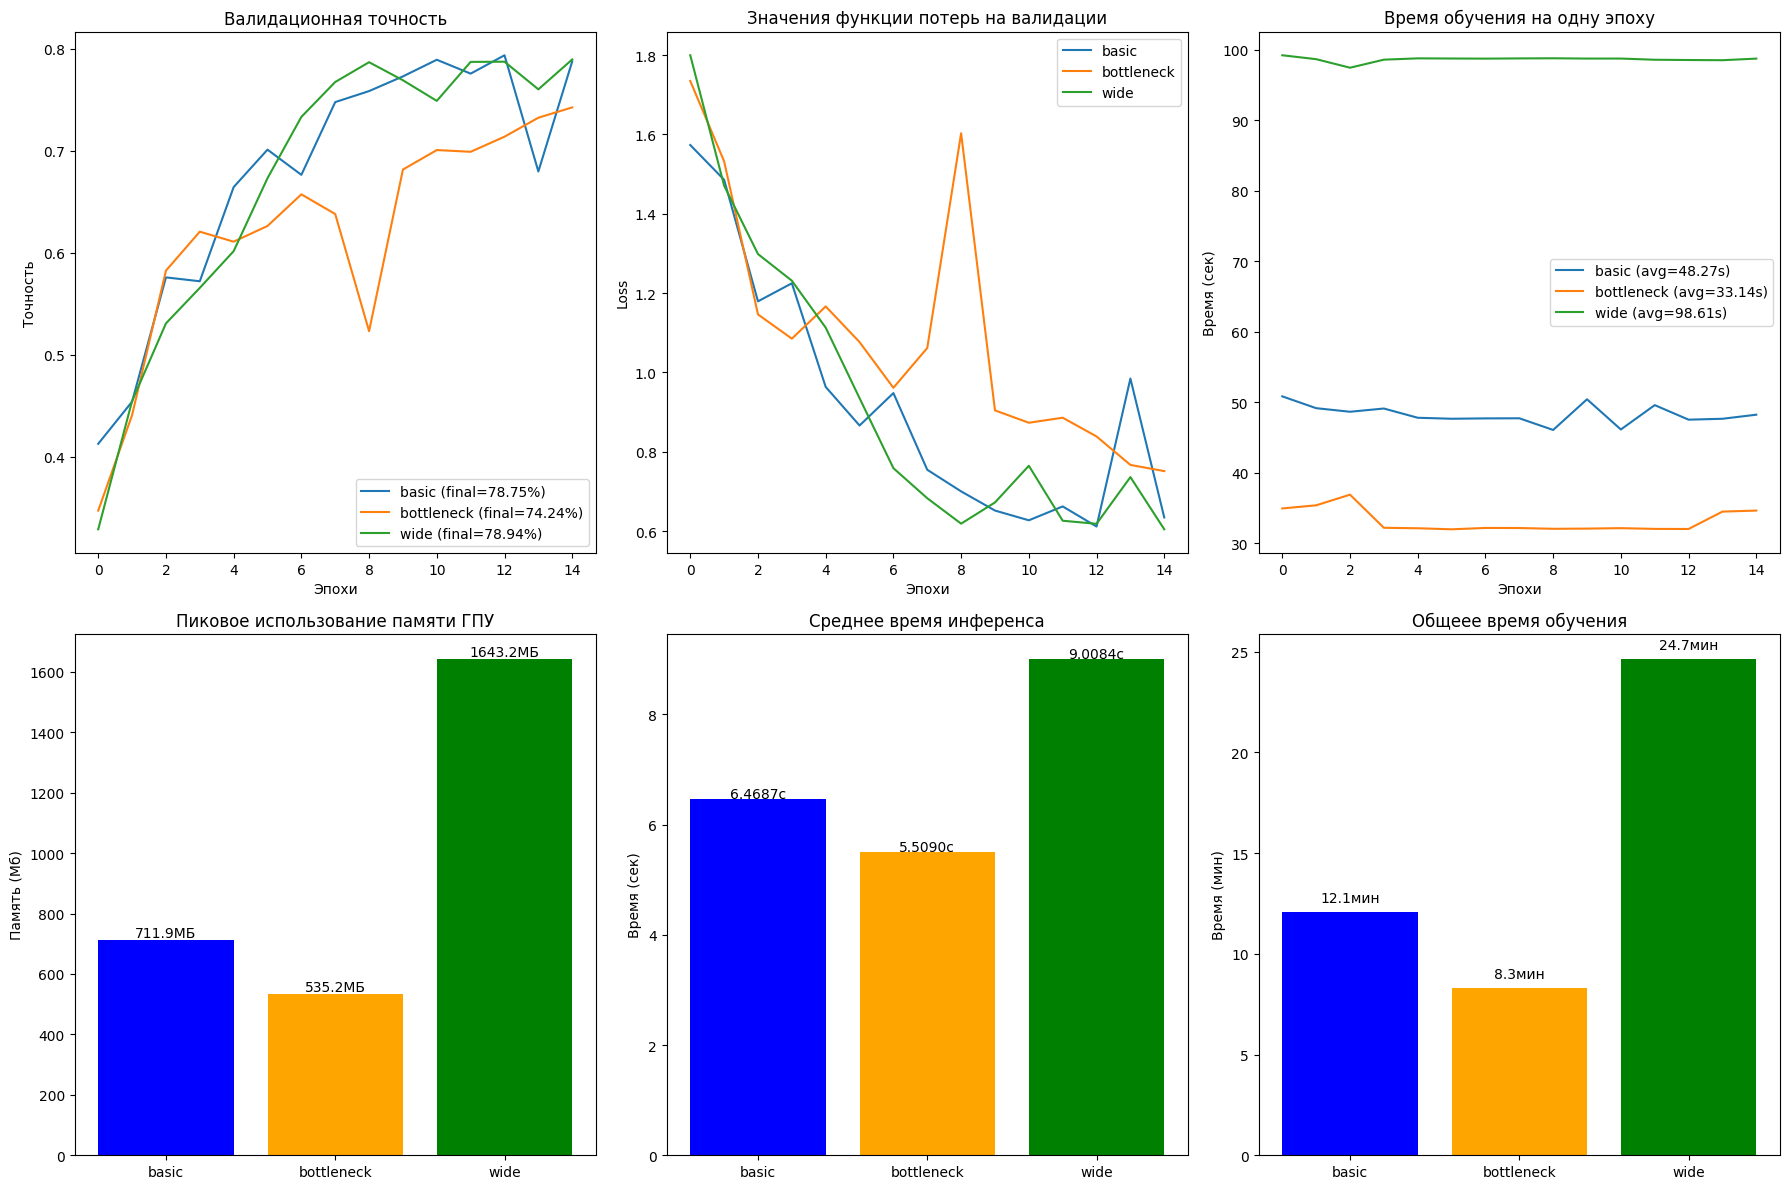

In [23]:
# Сравнительная таблица производительности
print("\n=== Сравнение производительности Residual блоков ===")
print("| Block Type  | Params (M) | Peak Memory (MB) | Avg Epoch Time (s) | Avg Inference (s) | Total Train Time (m) | Final Acc (%) |")
print("|-------------|------------|------------------|--------------------|-------------------|----------------------|---------------|")

for block_type in block_types:
    metrics = performance_metrics[block_type]
    print(f"| {block_type:11} | {metrics['parameters'] / 1e6:9.2f} | {metrics['peak_memory']:16.1f} | {metrics['avg_epoch_time']:18.2f} | {metrics['avg_inference_time']:17.4f} | {metrics['total_training_time'] / 60:20.1f} | {metrics['final_accuracy'] * 100:13.2f} |")

# Анализ эффективности
print("\n=== Эффективность Residual блоков ===")
print("| Block Type  | Acc/Param (1/M) | Acc/Time (1/min) | Acc/Memory (1/MB) |")
print("|-------------|-----------------|------------------|-------------------|")

for block_type in block_types:
    metrics = performance_metrics[block_type]
    acc_per_param = metrics['final_accuracy'] / (metrics['parameters'] / 1e6)
    acc_per_time = metrics['final_accuracy'] / (metrics['total_training_time'] / 60)
    acc_per_mem = metrics['final_accuracy'] / metrics['peak_memory'] if metrics['peak_memory'] > 0 else 0
    
    print(f"| {block_type:11} | {acc_per_param:15.4f} | {acc_per_time:16.4f} | {acc_per_mem:17.6f} |")

visualize_results(block_types, results)